# Sea Ice Semantic Segmentation

Florian Frick, Jen MacDonald

April 2024

### Imports

In [ ]:
!pip install datasets -qq
!pip install accelerate -U -qq
!pip install transformers -U -qq
!pip install evaluate -qq

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from PIL import Image
from datasets import Dataset, DatasetDict, Image

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

### Import Data (357x306 resolution)

In [ ]:
if os.path.exists('./arctic-sea-ice-image-masking.zip') == False:
  !kaggle datasets download -d alexandersylvester/arctic-sea-ice-image-masking
  ! unzip -q "arctic-sea-ice-image-masking.zip"

### Load data, split training and testing sets, and apply map to masks

In [ ]:
image_paths = sorted([os.path.join('./Images/', path) for path in os.listdir('./Images')])
mask_paths = sorted([os.path.join('./Masks/', path) for path in os.listdir('./Masks')])

In [ ]:
mask_lib = {0:0,
            1:0, #<1/10 (open water)
            2:0, #bergy water
            10:1, #1/10
            20:1, #2/20
            30:2, #...
            40:2,
            50:3,
            60:3,
            70:4, #7/10
            80:4, #8/10
            90:5, #9/10
            91:5, #9/10-10/10
            92:6, #10/10 - fast ice
            100:7, #land
           }

def map_mask(mask, lib=mask_lib):
    for key, val in lib.items():
        mask[mask==key] = val
    mask = Image.fromarray(mask)
    return mask

In [ ]:
from PIL import Image
def create_dataset(image_paths, mask_paths):
    images = [Image.open(img_path) for img_path in sorted(image_paths)]
    masks = [map_mask(np.array(Image.open(mask_path))) for mask_path in sorted(mask_paths)]

    dataset = Dataset.from_dict({"pixel_values": images,
                                "label": masks})
    return dataset

ds = create_dataset(image_paths, mask_paths)

ds = ds.train_test_split(test_size=0.3, seed=42)

#### Visualize data before preprocessing

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 2374
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1018
    })
})

(array([5, 6, 7], dtype=uint8), array([14517, 22828, 71897]))


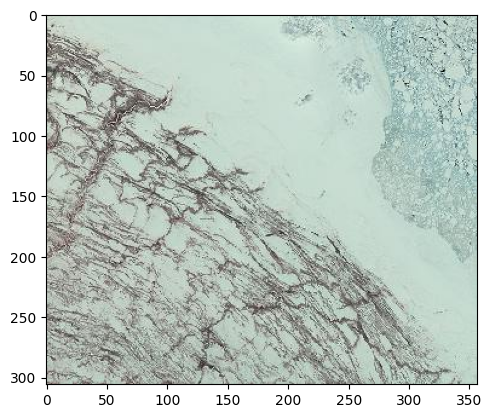

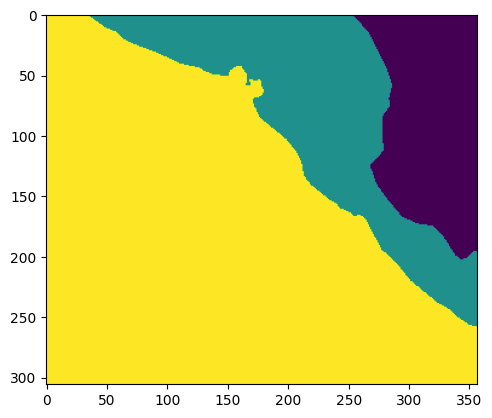

In [ ]:
print(np.unique(ds['train'][6]['label'], return_counts=True))
plt.imshow(ds['train'][6]['pixel_values'])
plt.show()

plt.imshow(ds['train'][6]['label'])
plt.show()

### Image Preprocessing

In [ ]:
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomVerticalFlip
from transformers import SegformerImageProcessor
from torchvision.transforms import functional as F


processor = SegformerImageProcessor(do_resize=True, size={"height": 256, "width": 256})


def transform_image_and_mask(image, mask):
    angle = random.uniform(-10, 10)
    image = F.rotate(image, angle)
    mask = F.rotate(mask, angle)

    if random.random() > 0.5:
        image = F.hflip(image)
        mask = F.hflip(mask)
    if random.random() > 0.5:
        image = F.vflip(image)
        mask = F.vflip(mask)

    return image, mask

def train_transforms(samples):
    images, masks = zip(*[transform_image_and_mask(image, mask) for image, mask in zip(samples['pixel_values'], samples['label'])])
    inputs = processor(images, masks)
    return inputs

def test_transforms(samples):
    images = samples['pixel_values']
    masks = samples['label']
    inputs = processor(images, masks)
    return inputs

ds['train'].set_transform(train_transforms)
ds['test'].set_transform(test_transforms)

#### Visualize Data after preprocessing

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 2374
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1018
    })
})

(array([0, 1, 5, 6, 7]), array([ 7443, 44012, 10760,  1028,  2293]))


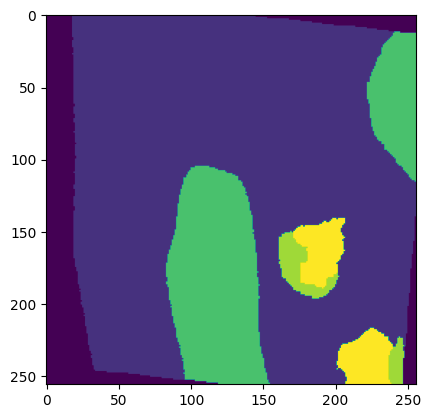

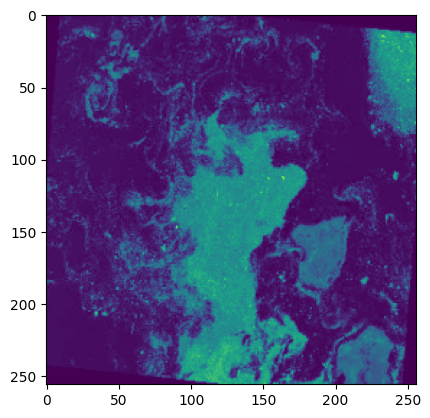

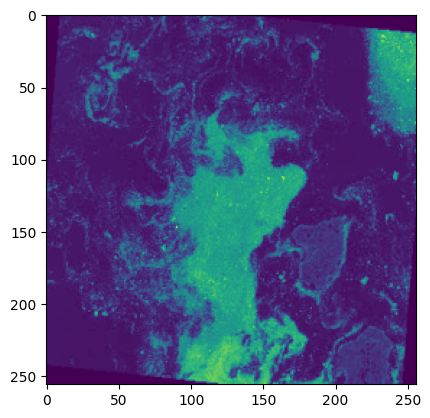

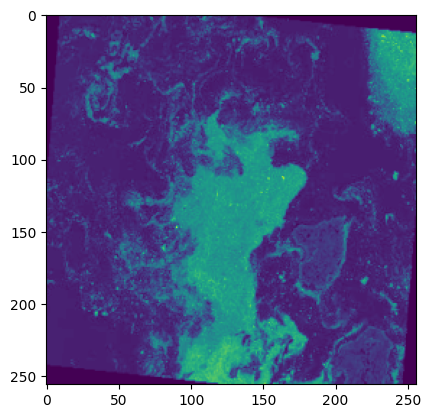

In [ ]:
test_img = ds['train'][2]

print(np.unique(test_img['labels'], return_counts=True))
# print(np.unique(ds['train'][:1000]['labels']))

plt.imshow(test_img['labels'])
plt.show()

plt.imshow(test_img['pixel_values'][0])
plt.show()
plt.imshow(test_img['pixel_values'][1])
plt.show()
plt.imshow(test_img['pixel_values'][2])
plt.show()

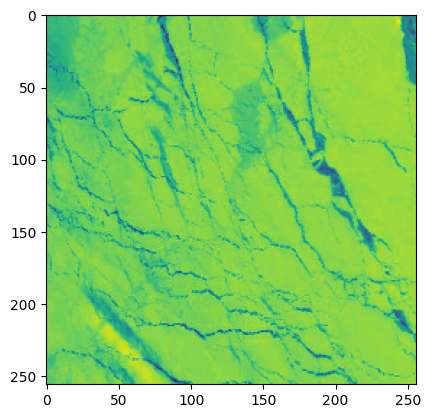

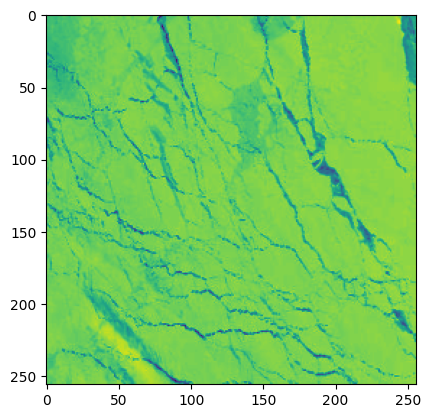

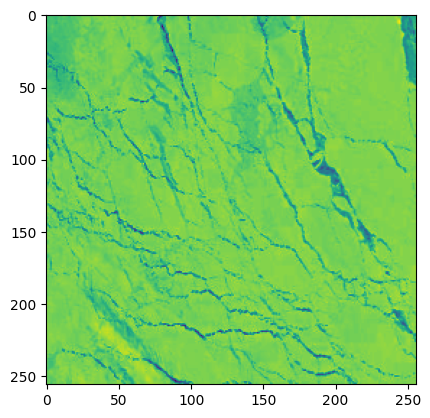

In [ ]:
test_img = ds['test'][0]
plt.imshow(test_img['pixel_values'][0])
plt.show()
plt.imshow(test_img['pixel_values'][1])
plt.show()
plt.imshow(test_img['pixel_values'][2])
plt.show()

### Load Pretrained segformer

In [ ]:
model_version = "b4"

In [ ]:
from transformers import SegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-"+model_version
id2label = {0: "open_water", 1: "conc_1", 2: "conc_2", 3: "conc_3", 4: "conc_4", 5: "conc_5", 6: "conc_6", 7: "land"}
label2id = {label: id for id, label in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model

### Train Model

In [ ]:
from transformers import TrainingArguments

epochs = 30
lr = 0.00006
batch_size = 15
eval_batch_size = 15

training_args = TrainingArguments(
    model_version+"-training-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [ ]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)

    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    )

    pred_labels = logits_tensor.argmax(dim=1).detach().cpu().numpy()

    del logits_tensor
    torch.cuda.empty_cache()


    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    del pred_labels
    torch.cuda.empty_cache()

    return metrics

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Open Water,Accuracy Conc 1,Accuracy Conc 2,Accuracy Conc 3,Accuracy Conc 4,Accuracy Conc 5,Accuracy Conc 6,Accuracy Land,Iou Open Water,Iou Conc 1,Iou Conc 2,Iou Conc 3,Iou Conc 4,Iou Conc 5,Iou Conc 6,Iou Land
1,0.645100,0.427473,0.443931,0.533723,0.865313,0.918821,0.087766,0.000000,0.540223,0.348157,0.976753,0.517101,0.880966,0.796981,0.080605,0.000000,0.263205,0.259514,0.888111,0.436673,0.826357
2,0.420200,0.392820,0.476511,0.558660,0.875852,0.933474,0.341748,0.000000,0.389452,0.348129,0.979861,0.587946,0.888669,0.808469,0.237156,0.000000,0.251537,0.262956,0.893147,0.515964,0.842860
3,0.374300,0.374145,0.474300,0.583757,0.874752,0.888848,0.724634,0.000000,0.108061,0.442306,0.968377,0.634107,0.903720,0.807589,0.280028,0.000000,0.094556,0.288075,0.906301,0.550980,0.866870
4,0.348400,0.369982,0.491183,0.596301,0.880704,0.928740,0.535392,0.000000,0.369831,0.299651,0.966930,0.772347,0.897517,0.822421,0.298188,0.000000,0.217507,0.257656,0.909142,0.574343,0.850208
5,0.323000,0.367345,0.491814,0.589775,0.880185,0.876206,0.518195,0.000000,0.293155,0.423468,0.973839,0.721087,0.912251,0.817111,0.290156,0.000000,0.200339,0.253103,0.908847,0.592943,0.872012
6,0.295800,0.359237,0.500727,0.608240,0.881567,0.932159,0.347361,0.009043,0.537371,0.373901,0.955264,0.802230,0.908595,0.819597,0.258905,0.009042,0.246481,0.279496,0.907798,0.616359,0.868136
7,0.269600,0.367291,0.499720,0.598678,0.885393,0.932736,0.478021,0.003710,0.329418,0.373503,0.972102,0.801721,0.898210,0.823494,0.276481,0.003695,0.233317,0.273209,0.909016,0.609045,0.869500
8,0.252600,0.373791,0.497390,0.591987,0.884334,0.941939,0.364474,0.040669,0.242997,0.476411,0.963170,0.793086,0.913151,0.819876,0.263873,0.037494,0.165198,0.290551,0.910936,0.616876,0.874320
9,0.242500,0.374115,0.496972,0.592052,0.884575,0.914221,0.527310,0.009167,0.256728,0.387318,0.974076,0.757852,0.909741,0.827704,0.289599,0.008561,0.187830,0.263446,0.907045,0.612372,0.879220
10,0.210000,0.390167,0.499838,0.600084,0.878447,0.895821,0.489236,0.041057,0.265438,0.463242,0.952866,0.763948,0.929065,0.811773,0.283399,0.038140,0.189094,0.295538,0.898931,0.625739,0.856087


Buffered data was truncated after reaching the output size limit.

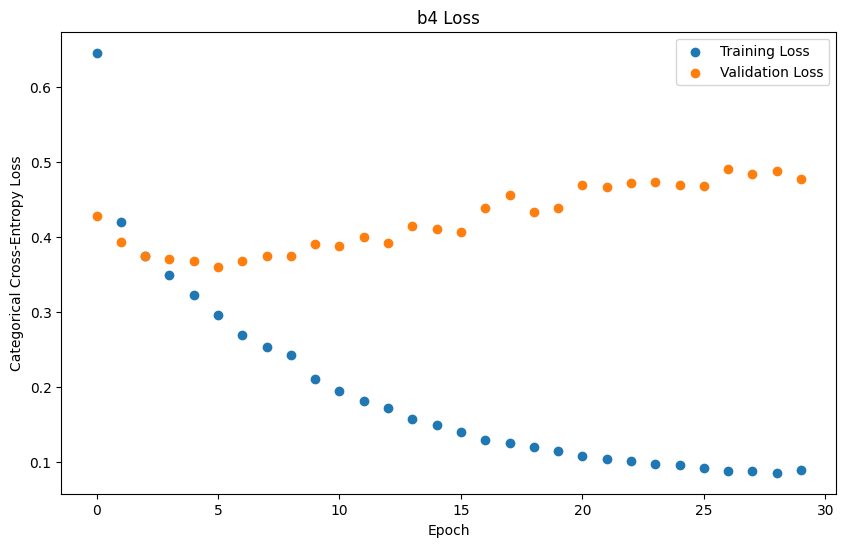

In [ ]:
loss_history = pd.DataFrame(trainer.state.log_history)['loss'].dropna()
eval_loss_history = pd.DataFrame(trainer.state.log_history)['eval_loss'].dropna()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(loss_history)), loss_history, label='Training Loss')
plt.scatter(range(len(eval_loss_history)), eval_loss_history, label='Validation Loss')
plt.title(model_version + " Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.legend()

# Displaying the plot
plt.show()

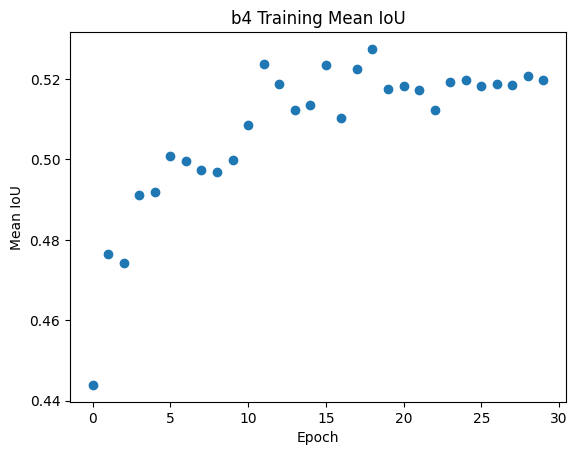

In [ ]:
iou_history = pd.DataFrame(trainer.state.log_history)['eval_mean_iou'].dropna()
plt.scatter(range(len(iou_history)), iou_history)
plt.title(model_version+" Training Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU");

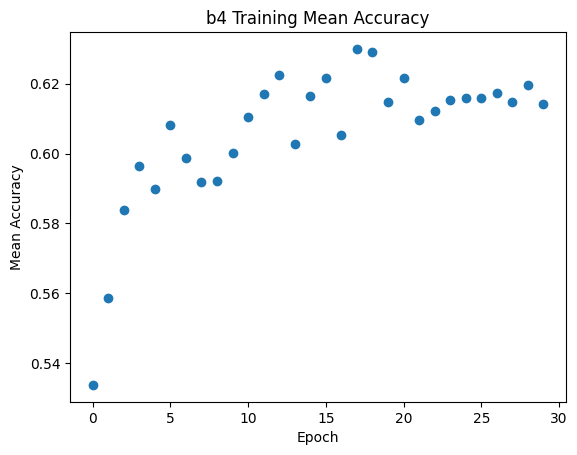

In [ ]:
acc_history = pd.DataFrame(trainer.state.log_history)['eval_mean_accuracy'].dropna()
plt.scatter(range(len(acc_history)), acc_history)
plt.title(model_version+" Training Mean Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy");

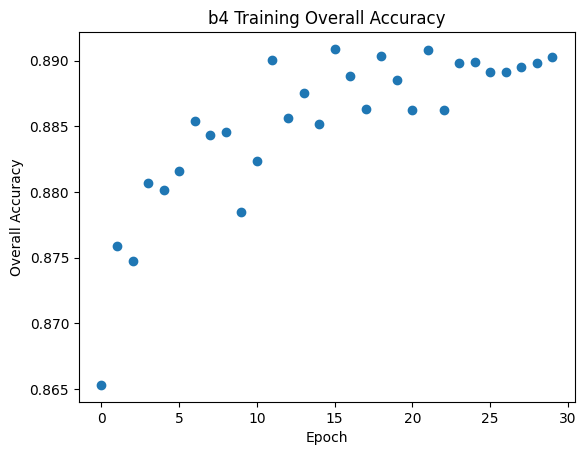

In [ ]:
acc_history = pd.DataFrame(trainer.state.log_history)['eval_overall_accuracy'].dropna()
plt.scatter(range(len(acc_history)), acc_history)
plt.title(model_version+" Training Overall Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Overall Accuracy");

In [ ]:
import time

start_time = time.time()
predictions, labels, _ = trainer.predict(ds['test']) # run inference on test set
end_time = time.time()
inference_time = end_time - start_time

metrics = compute_metrics((predictions, labels))
print("Metrics:", metrics)
print("Test size:", len(ds['test']))
print(model_version+" Inference on test ds:", inference_time)

Metrics: {'mean_iou': 0.5007268819295086, 'mean_accuracy': 0.6082404480581629, 'overall_accuracy': 0.8815670200790076, 'accuracy_open_water': 0.9321589375764484, 'accuracy_conc_1': 0.34736106665353456, 'accuracy_conc_2': 0.009042592030375116, 'accuracy_conc_3': 0.5373712686545263, 'accuracy_conc_4': 0.3739011149796149, 'accuracy_conc_5': 0.955264022388071, 'accuracy_conc_6': 0.8022300642850545, 'accuracy_land': 0.9085945178976783, 'iou_open_water': 0.8195974017495324, 'iou_conc_1': 0.25890531129934635, 'iou_conc_2': 0.009042453029586844, 'iou_conc_3': 0.2464810421564204, 'iou_conc_4': 0.2794957121495339, 'iou_conc_5': 0.907798253760637, 'iou_conc_6': 0.6163585797932553, 'iou_land': 0.8681363014977572}
Test size: 1018
b4 Inference on test ds: 36.32635188102722


### Inference

In [ ]:
# Adjust checkpoint path to match best iteration of training, for inference:
checkpoint_path = "./b4-training-outputs/checkpoint-954"

model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path)

device = torch.device("cuda")
model = model.to(device)

In [ ]:
print(model_version+" parameters: ", sum(p.numel() for p in model.parameters()))

b4 parameters:  63999176


In [ ]:
#define a colormap for the mask
n_colors=8
ice_colors = n_colors-1
jet = plt.get_cmap('jet', ice_colors)
newcolors = jet(np.linspace(0, 1, ice_colors))
black = np.array([[0, 0, 0, 1]])
newcolors = np.concatenate((newcolors, black), axis=0)
cmap = ListedColormap(newcolors)

In [ ]:
np.random.seed(123)
ten_rand_imgs = np.random.choice(len(image_paths), 10)
ten_rand_image_paths = np.take(image_paths, ten_rand_imgs)
ten_rand_mask_paths = np.take(mask_paths, ten_rand_imgs)

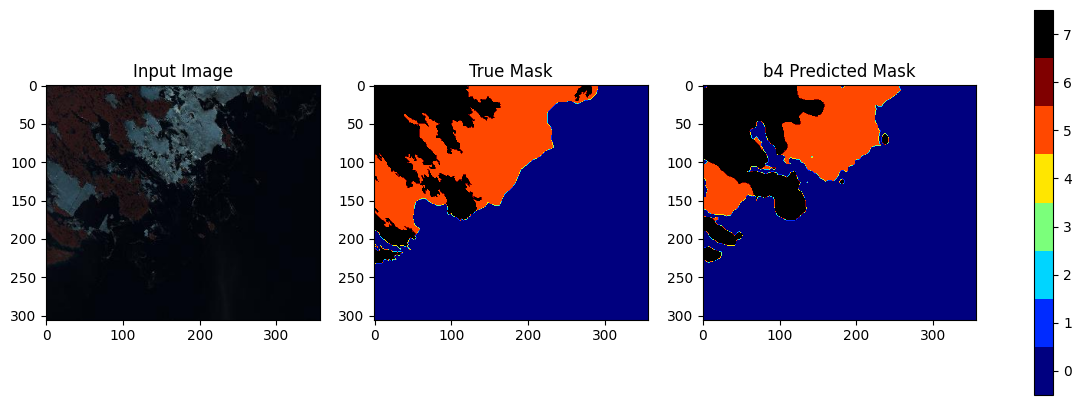

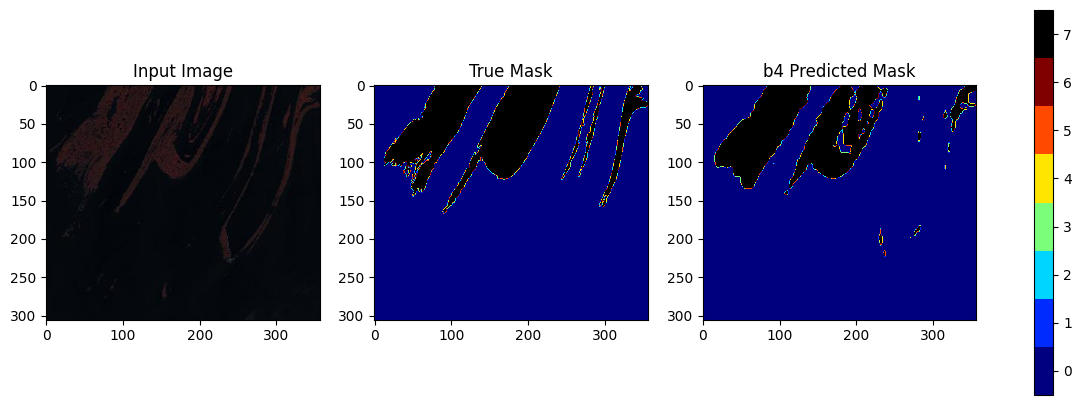

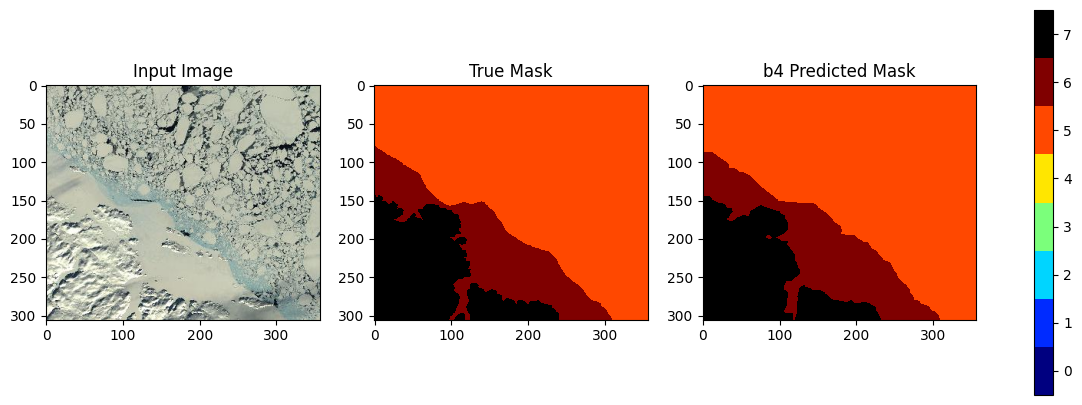

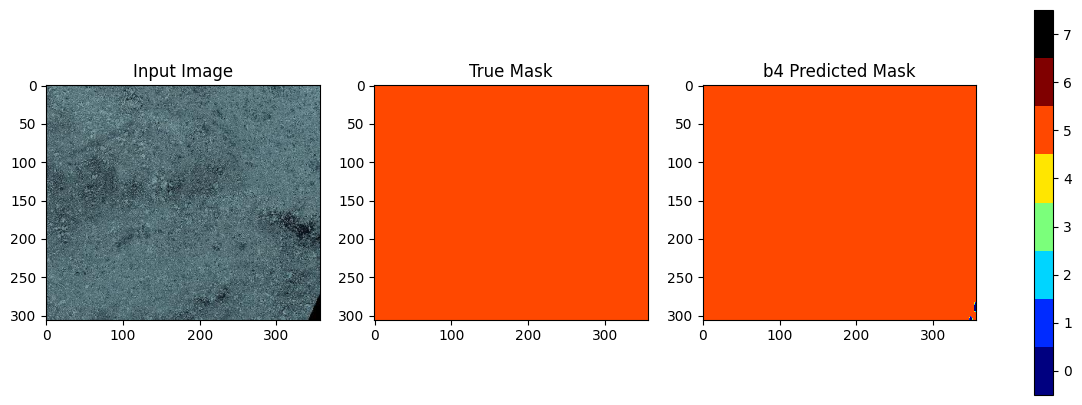

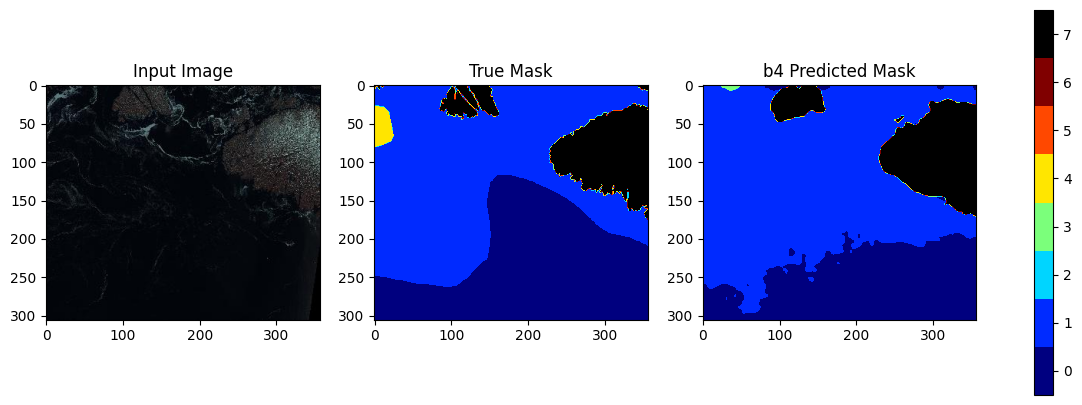

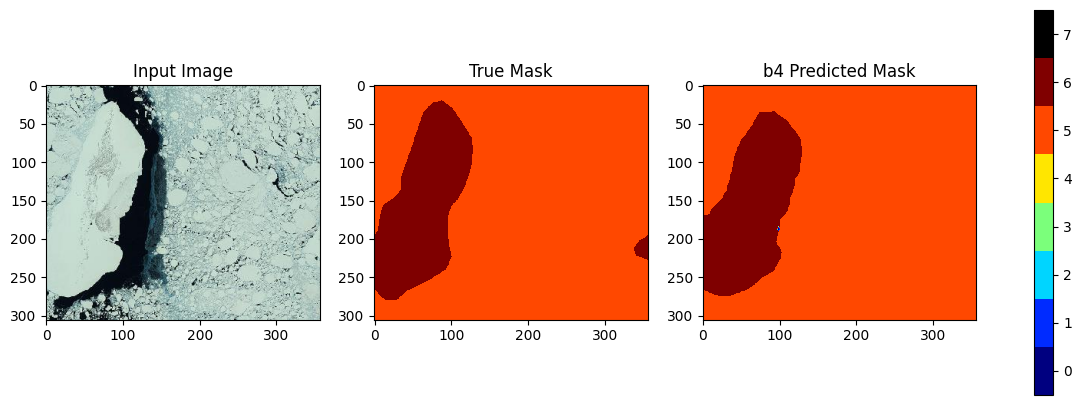

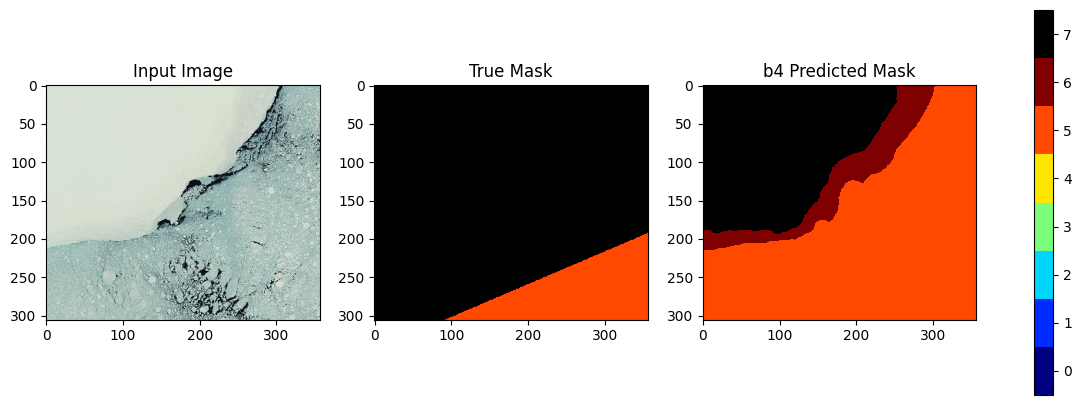

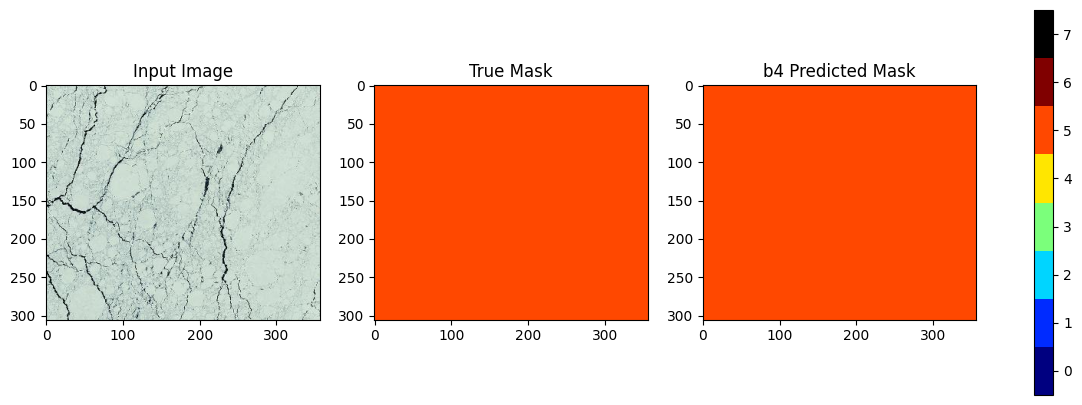

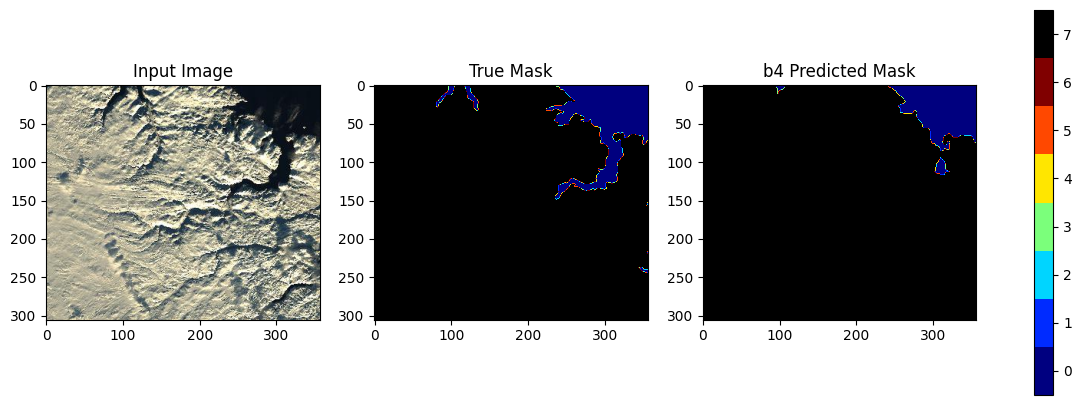

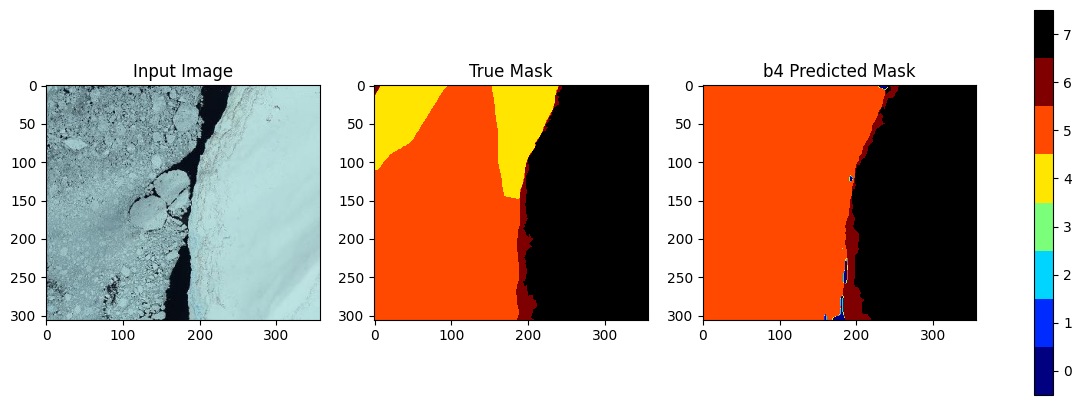

In [ ]:
import torch

# predict mask of ten random images
for i in range(len(ten_rand_imgs)):
  test_image = Image.open(ten_rand_image_paths[i])
  test_mask = map_mask(np.array(Image.open(ten_rand_mask_paths[i])))

  pixel_values = processor(test_image, return_tensors="pt").pixel_values.to(device)

  with torch.no_grad():
      outputs = model(pixel_values)

  logits = outputs.logits.cpu()

  post_processed = processor.post_process_semantic_segmentation(outputs, target_sizes=[test_image.size[::-1]])[0]

  predicted_mask_np = post_processed.detach().cpu().numpy()



  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  # Plot the test image
  axs[0].imshow(test_image)
  axs[0].set_title('Input Image')

  # Plot the test mask
  im1 = axs[1].imshow(test_mask, cmap = cmap, vmin=0, vmax=n_colors-1)
  axs[1].set_title('True Mask')

  # Plot the predicted mask
  im2 = axs[2].imshow(predicted_mask_np, cmap = cmap, vmin=0, vmax=n_colors-1)
  axs[2].set_title(model_version+' Predicted Mask')

  cbar = fig.colorbar(im2, ax=axs, location='right')
  tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors
  cbar.set_ticks(tick_locs)
  cbar.set_ticklabels(np.arange(n_colors))

  plt.show()